## High level computation: groupby, resample, rolling, coarsen, weighted

Xarray has some very useful high level objects that let you do common
computations:

- `groupby` :
  [Bin data in to groups and reduce](https://xarray.pydata.org/en/stable/groupby.html)
- `resample` :
  [Groupby specialized for time axes. Either downsample or upsample your data](https://xarray.pydata.org/en/stable/time-series.html#resampling-and-grouped-operations).
- `rolling` :
  [Operate on rolling windows of your data e.g. running mean](https://xarray.pydata.org/en/stable/computation.html#rolling-window-operations)
- `coarsen` :
  [Downsample your data](https://xarray.pydata.org/en/stable/computation.html#coarsen-large-arrays)
- `weighted` :
  [Weight your data before applying reductions](https://xarray.pydata.org/en/stable/computation.html#weighted-array-reductions)

In [1]:
import xarray as xr
filename='/scratch/training/intro_pangeo/datasets/b.e13.B1950TRC5.ne30_g16.ihesp24_1950-2050.002.pop.h.nday1.SST.195001-204912.nc'
ds = xr.open_dataset(filename, decode_times=True)
ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1200)
Coordinates:
  * time        (time) object 1950-01-17 12:00:00 ... 2049-12-17 00:00:00
    TLONG       (nlat, nlon) float64 ...
    TLAT        (nlat, nlon) float64 ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object ...
    SST         (time, nlat, nlon) float32 ...
Attributes: (12/13)
    title:           b.e13.B1950TRC5.ne30_g16.ihesp24_1950-2050.002
    history:         Sun Apr 18 15:07:00 2021: ncrcat b.e13.B1950TRC5.ne30_g1...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2020-03-06 at 14:32:37.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    25
    tavg_sum:        86400.0
    tavg_sum_qflux:  86400.0
    NCO:             netCDF Operators version 4.9.7 (Homepage = http://nco.sf...

### Aggregation (Reduction) Methods

Xarray supports many of the aggregations methods that numpy has. A partial list
includes: all, any, argmax, argmin, max, mean, median, min, prod, sum, std, var.

Whereas the numpy syntax would require scalar axes, xarray can use dimension
names:

In [2]:
mean_salt = ds.SST.mean(dim='time')
mean_salt

<xarray.DataArray 'SST' (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [-1.7586812, -1.7581894, -1.7569336, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon

### groupby

In [3]:
# seasonal groups
seasonal_mean=ds.groupby("time.season").mean(dim='time')

In [4]:
#The seasons are out of order (they are alphabetically sorted). This is a common annoyance. The solution is to use .reindex
seasonal_mean = seasonal_mean.reindex(season=["DJF", "MAM", "JJA", "SON"])
seasonal_mean

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, season: 4)
Coordinates:
  * season   (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon
Data variables:
    SST      (season, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan

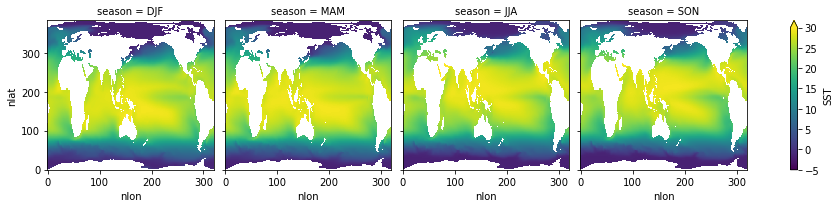

In [5]:
seasonal_mean.SST.plot(col="season", robust=True, vmin=-5, vmax=30)

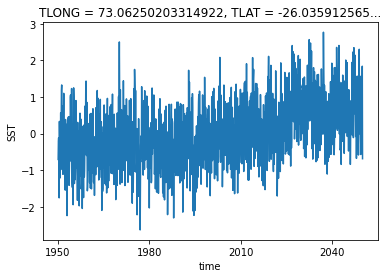

In [6]:
import nc_time_axis #Required for plotting of arrays of/ or indexed by cftime.datetime objects requires
sst_anom = ds.groupby('time.season') - seasonal_mean
#sst_anom.SST.sel(TLONG=230, TLAT=45, method='nearest').plot()
sst_anom.SST.isel(nlat=100,nlon=100).plot(label="monthly SST anomaly")
#sst_anom.plot(col="season", robust=True)

### resample
`resample` is effectively a group-by operation, and uses the same basic syntax. It can be applied only to time-index
dimensions. Here we resample the raw monthly SST data to bi-monthly frequency. 

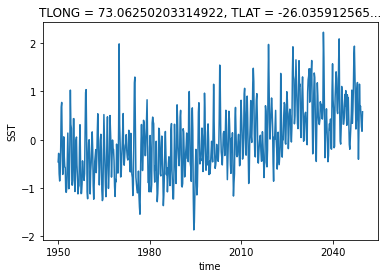

In [7]:
# resample to bi-monthly frequency
resampled_sst_anom = sst_anom.resample(time="2MS").mean()
resampled_sst_anom.SST.isel(nlat=100,nlon=100).plot()

### rolling window operations
`rolling` can be applied along any dimension. It works with logical coordinates.

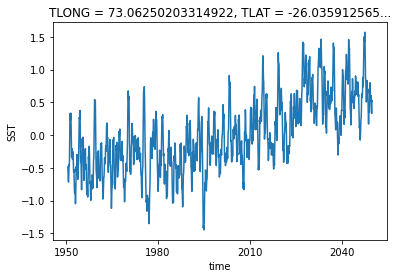

In [8]:
# A rolling mean with a window size of 7
roll_sst_anom=sst_anom.rolling(time=7).mean()
roll_sst_anom.SST.isel(nlat=100,nlon=100).plot()

`coarsen` does something similar to `resample`, but without being aware of time.
It operates on logical coordinates only but can work on multiple dimensions at a
time.

In [14]:
coarse_sst_anom = sst_anom.coarsen(nlat=2,nlon=2).mean()
#coarse_sst_anom.SST.isel(nlat=100,nlon=100).plot(label="12 month rolling mean")
coarse_sst_anom

<xarray.Dataset>
Dimensions:  (nlat: 192, nlon: 160, time: 1200)
Coordinates:
  * time     (time) object 1950-01-17 12:00:00 ... 2049-12-17 00:00:00
    TLONG    (nlat, nlon) float64 321.1 323.4 325.6 327.9 ... 317.8 318.6 319.5
    TLAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.0 71.98 71.96
    season   (time) <U3 'DJF' 'DJF' 'MAM' 'MAM' ... 'SON' 'SON' 'SON' 'DJF'
Dimensions without coordinates: nlat, nlon
Data variables:
    SST      (time, nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan